In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error

# Load data

In [2]:
# Read data from csv
df = pd.read_csv("data/rental_prices_singapore_preprocessed.csv")

In [3]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               1680 non-null   int64  
 1   size                1680 non-null   int64  
 2   bedrooms            1680 non-null   object 
 3   bathrooms           1680 non-null   int64  
 4   latitude            1680 non-null   float64
 5   longitude           1680 non-null   float64
 6   meters_to_cbd       1680 non-null   int64  
 7   meters_to_school    1680 non-null   int64  
 8   restaurants_rating  1680 non-null   float64
 9   property_type       1680 non-null   object 
 10  furnishing          1680 non-null   object 
 11  year                1680 non-null   int64  
 12  meters_to_mrt       1680 non-null   int64  
 13  high_floor          1680 non-null   bool   
 14  new                 1680 non-null   bool   
 15  renovated           1680 non-null   bool   
 16  view  

In [4]:
# Show top five rows
df.head()

,price,size,bedrooms,bathrooms,latitude,longitude,meters_to_cbd,meters_to_school,restaurants_rating,property_type,furnishing,year,meters_to_mrt,high_floor,new,renovated,view,penthouse
0,3000,400,1,1,1.312952,103.887868,6744,422,4.126316,Apartment,Fully Furnished,2013,450,False,False,False,False,False
1,2000,1130,Room,1,1.328820,103.912904,14317,3422,3.800000,Apartment,Fully Furnished,2013,810,False,False,False,False,False
2,7400,3800,5,4,1.389444,103.857002,15497,568,4.710000,Apartment,Fully Furnished,2013,450,False,False,False,False,False
3,1000,120,Room,1,1.429261,103.828917,22825,1090,3.605263,Apartment,Fully Furnished,2013,700,False,False,False,False,False
4,4300,689,1,1,1.297356,103.836707,3070,1262,4.120000,Apartment,Fully Furnished,2013,420,False,False,False,False,False


# Handle rare categories

In [5]:
# Show category frequencies of bedrooms
df["bedrooms"].value_counts()

3         479
2         438
1         245
4         207
Room      135
5          89
6          39
Studio     27
7          14
8           5
9           1
10          1
Name: bedrooms, dtype: int64

In [6]:
# Combine 7, 8, 9 and 10 bedrooms into one category
df["bedrooms"]= df["bedrooms"].replace({"8": "7", "9": "7", "10": "7"})

# Rename this category to "7+"
df["bedrooms"]= df["bedrooms"].replace({"7": "7+"})

In [7]:
# Show category frequencies of bedrooms
df["bedrooms"].value_counts()

3         479
2         438
1         245
4         207
Room      135
5          89
6          39
Studio     27
7+         21
Name: bedrooms, dtype: int64

# Train-validation-test split

In [8]:
# Split the data into X features and y target
X = df.drop("price", axis=1)
y = df["price"]

In [9]:
# Split the data into training and temporary sets (70% train, 30% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary data into validation and test sets (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Note: This accomplishes a 70% training, 15% validation and 15% test set size.

# Handle outliers

Remove univariate outliers regarding the rental price based on 3 standard deviations (SD) or 1.5 interquartile ranges (IQR).

## 3 SD

Criterion for outliers: 3 standard deviations (SD) above or below the mean 

In [10]:
# Create a custom transformer class to handle outliers based on 3 SD
class OutlierHandler3SD(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        # Calculate mean, standard deviation, and cutoff values of target label (y)
        self.mean_ = y.mean()
        self.sd_ = y.std()
        self.lower_cutoff_ = self.mean_ - 3 * self.sd_
        self.upper_cutoff_ = self.mean_ + 3 * self.sd_
        print(f"Lower cutoff: {round(self.lower_cutoff_)} S$/month")
        print(f"Upper cutoff: {round(self.upper_cutoff_)} S$/month")
        return self

    def transform(self, X, y):
        # Apply cutoff values
        mask = (y >= self.lower_cutoff_) & (y <= self.upper_cutoff_)
        # Print number of outliers
        print(f"Rental price outliers based on 3 SD: {y.shape[0] - y[mask].shape[0]}")
        # Return data with outliers removed 
        return X[mask], y[mask]

    def fit_transform(self, X, y):
        # Perform both fit and transform 
        return self.fit(X, y).transform(X, y)

## 1.5 IQR

Criterion for outliers: 1.5 interquartile ranges (IQR) above the 3. quartile or below the 1. quartile 

In [11]:
# Create a custom transformer class to handle outliers based on 1.5 IQR
class OutlierHandlerIQR(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        # Calculate quartiles, IQR and cutoff values of target label (y) 
        Q1 = y.quantile(0.25)
        Q3 = y.quantile(0.75)
        IQR = Q3 - Q1
        self.lower_cutoff_ = Q1 - 1.5 * IQR
        self.upper_cutoff_ = Q3 + 1.5 * IQR
        print(f"Lower cutoff: {round(self.lower_cutoff_)} S$/month")
        print(f"Upper cutoff: {round(self.upper_cutoff_)} S$/month")
        return self

    def transform(self, X, y):
        # Apply cutoff values 
        mask = (y >= self.lower_cutoff_) & (y <= self.upper_cutoff_)
        # Print number of outliers
        print(f"Rental price outliers based on 1.5 IQR: {y.shape[0] - y[mask].shape[0]}")
        # Return data with outliers removed 
        return X[mask], y[mask]

    def fit_transform(self, X, y):
        # Perform both fit and transform
        return self.fit(X, y).transform(X, y)

# Train baseline models

Train five baseline models: Linear regression, support vector machine, random forest, neural network, and XGBoost. Train each model (a) without handling outliers, (b) handling outliers based on 3 standard deviations (SD), and (c) handling outliers based on 1.5 interquartile ranges (IQR).

Model: LinearRegression()
Outlier handling: None
RMSE: 6224.43
MAPE: 0.37
R-squared (R²): 0.62


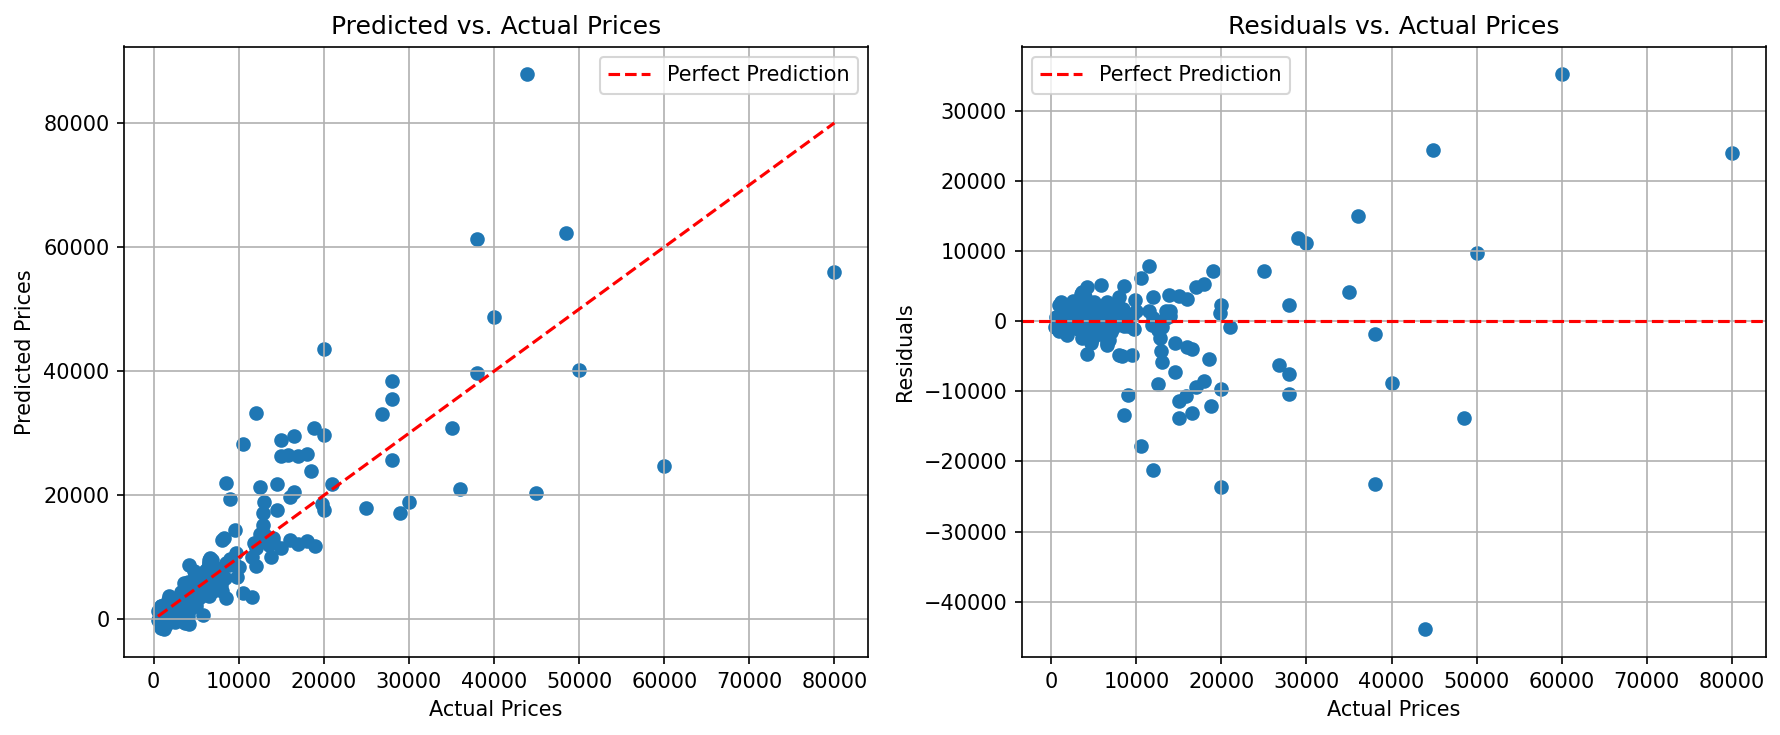

Model: SVR(C=100)
Outlier handling: None
RMSE: 9138.99
MAPE: 0.4
R-squared (R²): 0.19


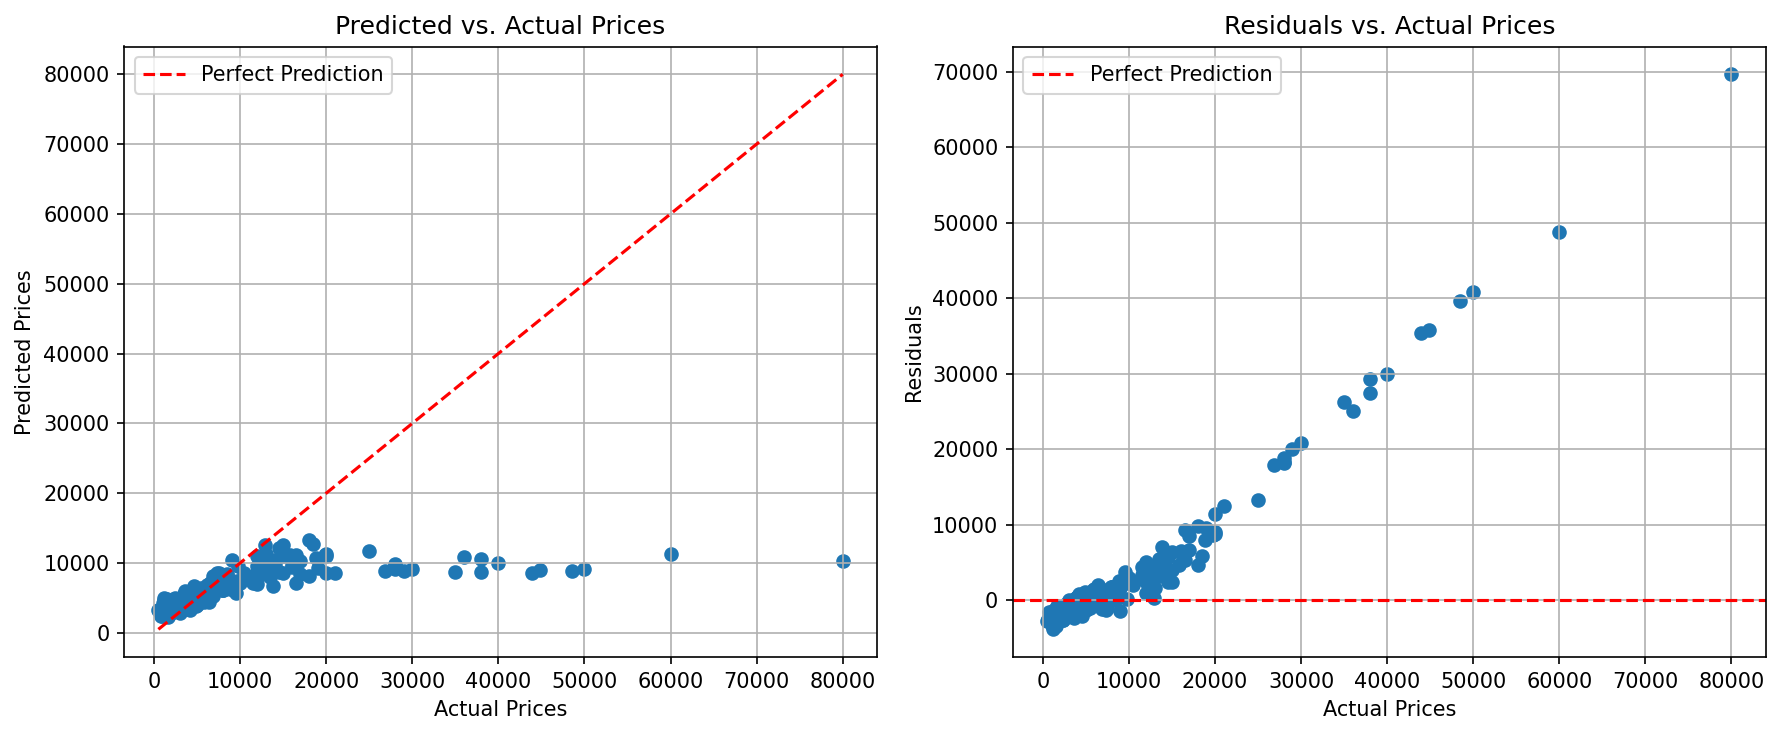

Model: RandomForestRegressor()
Outlier handling: None
RMSE: 4897.2
MAPE: 0.19
R-squared (R²): 0.77


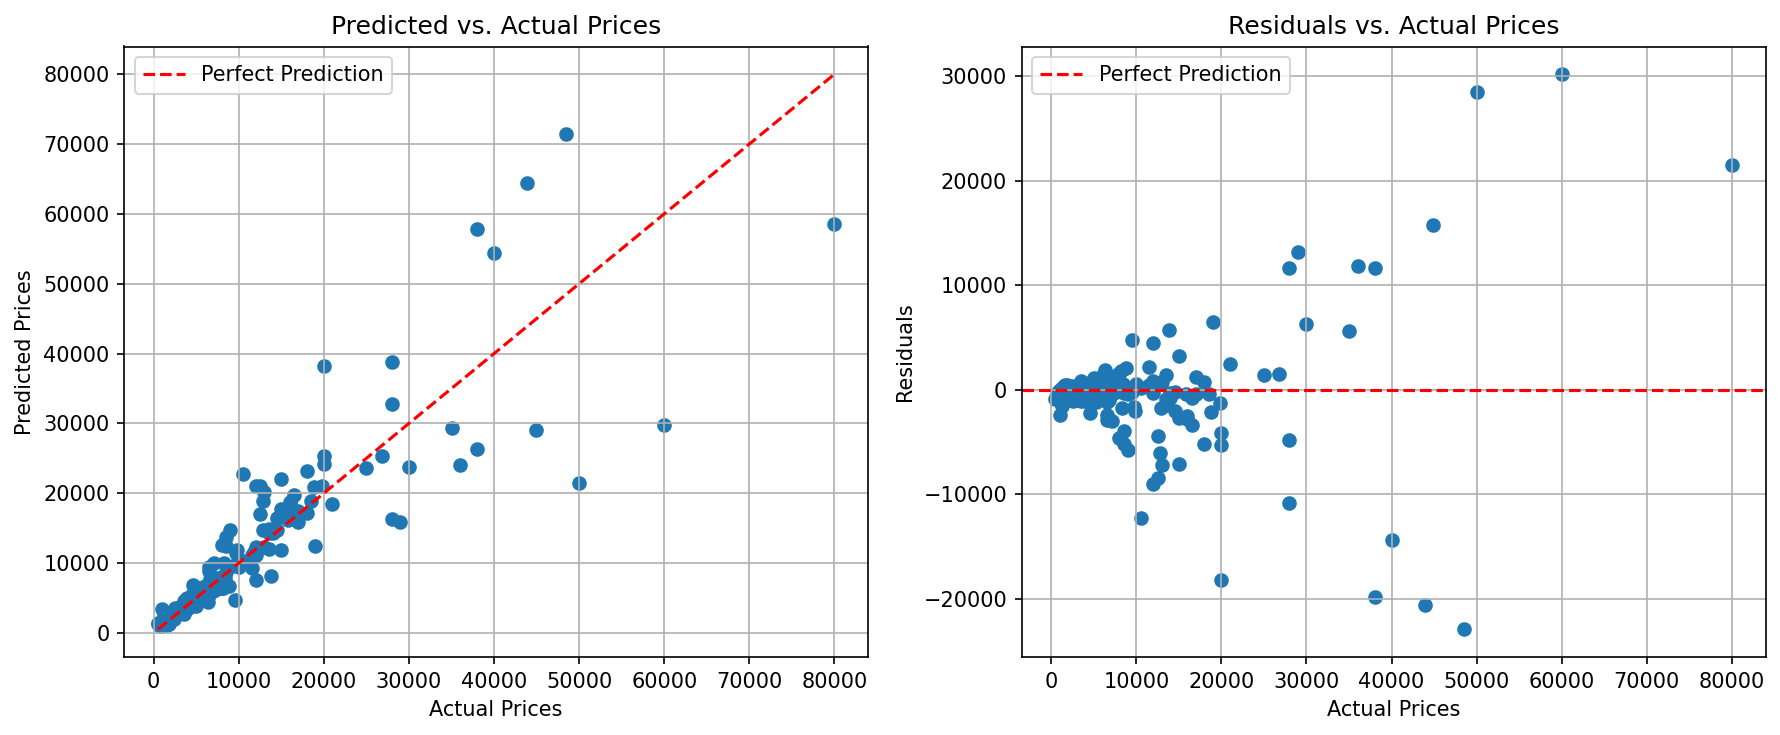

Model: MLPRegressor(max_iter=1000)
Outlier handling: None


C:\Users\Jens\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


RMSE: 6291.21
MAPE: 0.58
R-squared (R²): 0.62


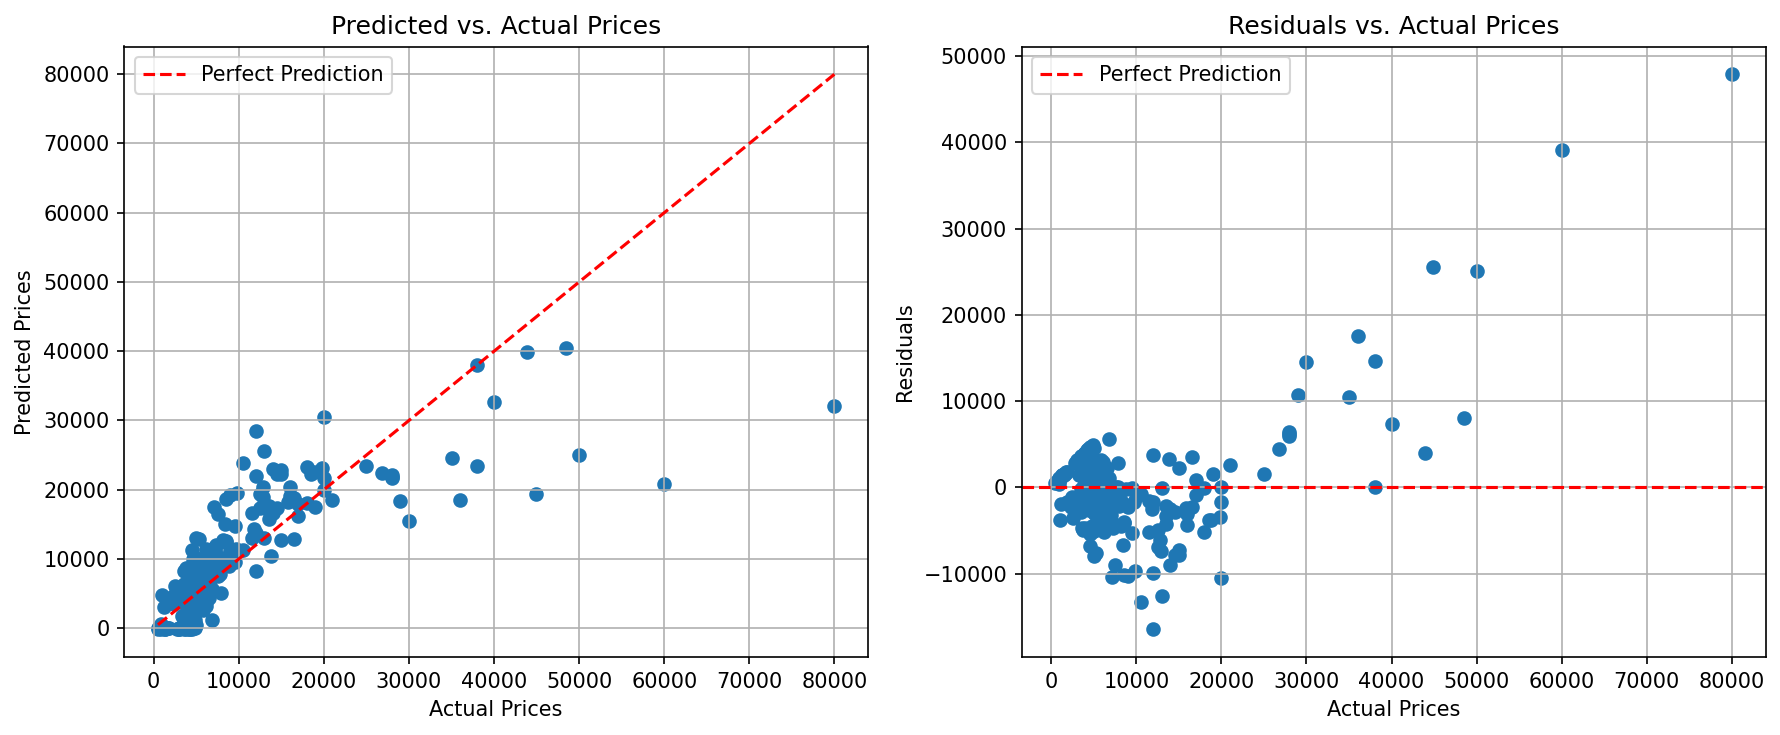

Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Outlier handling: None
RMSE: 4699.09
MAPE: 0.21
R-squared (R²): 0.79


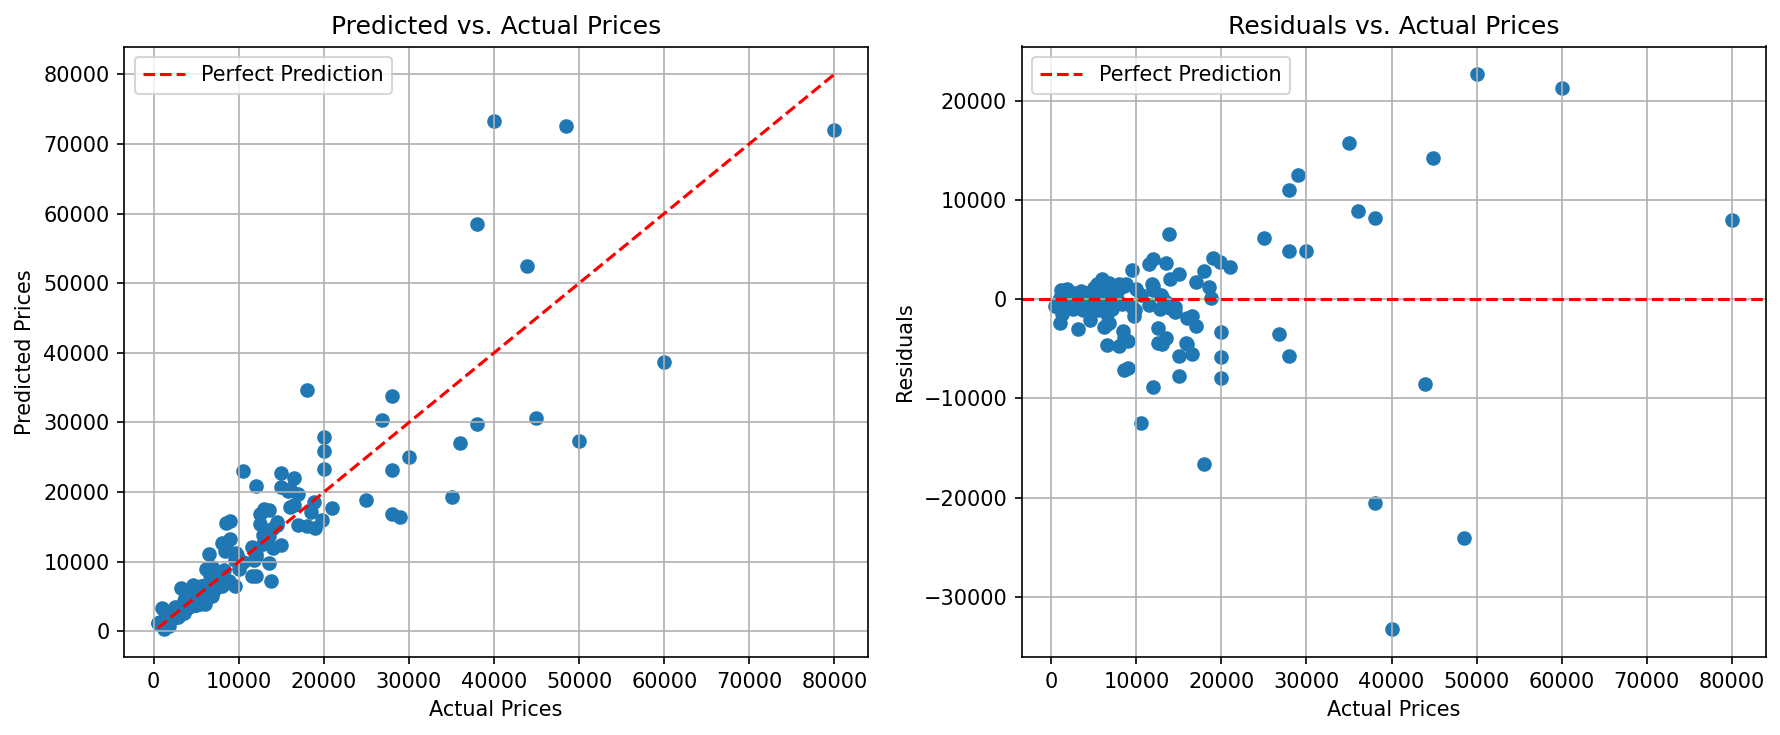

Model: LinearRegression()
Outlier handling: OutlierHandler3SD()
Lower cutoff: -37337 S$/month
Upper cutoff: 56094 S$/month
Rental price outliers based on 3 SD: 29
Rental price outliers based on 3 SD: 2
RMSE: 3896.71
MAPE: 0.28
R-squared (R²): 0.79


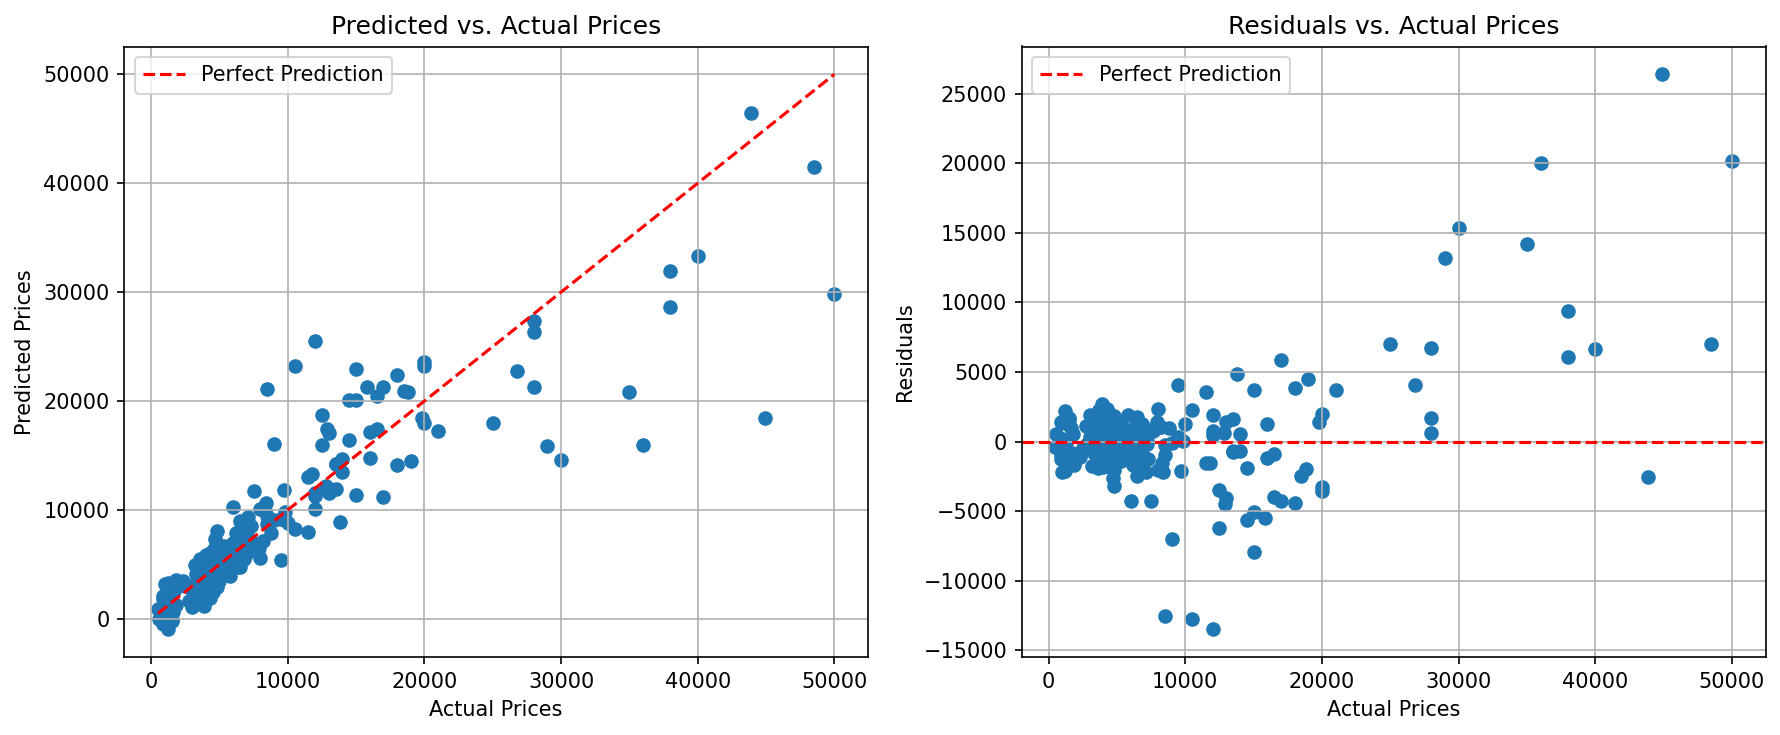

Model: SVR(C=100)
Outlier handling: OutlierHandler3SD()
Lower cutoff: -37337 S$/month
Upper cutoff: 56094 S$/month
Rental price outliers based on 3 SD: 29
Rental price outliers based on 3 SD: 2
RMSE: 7579.4
MAPE: 0.38
R-squared (R²): 0.22


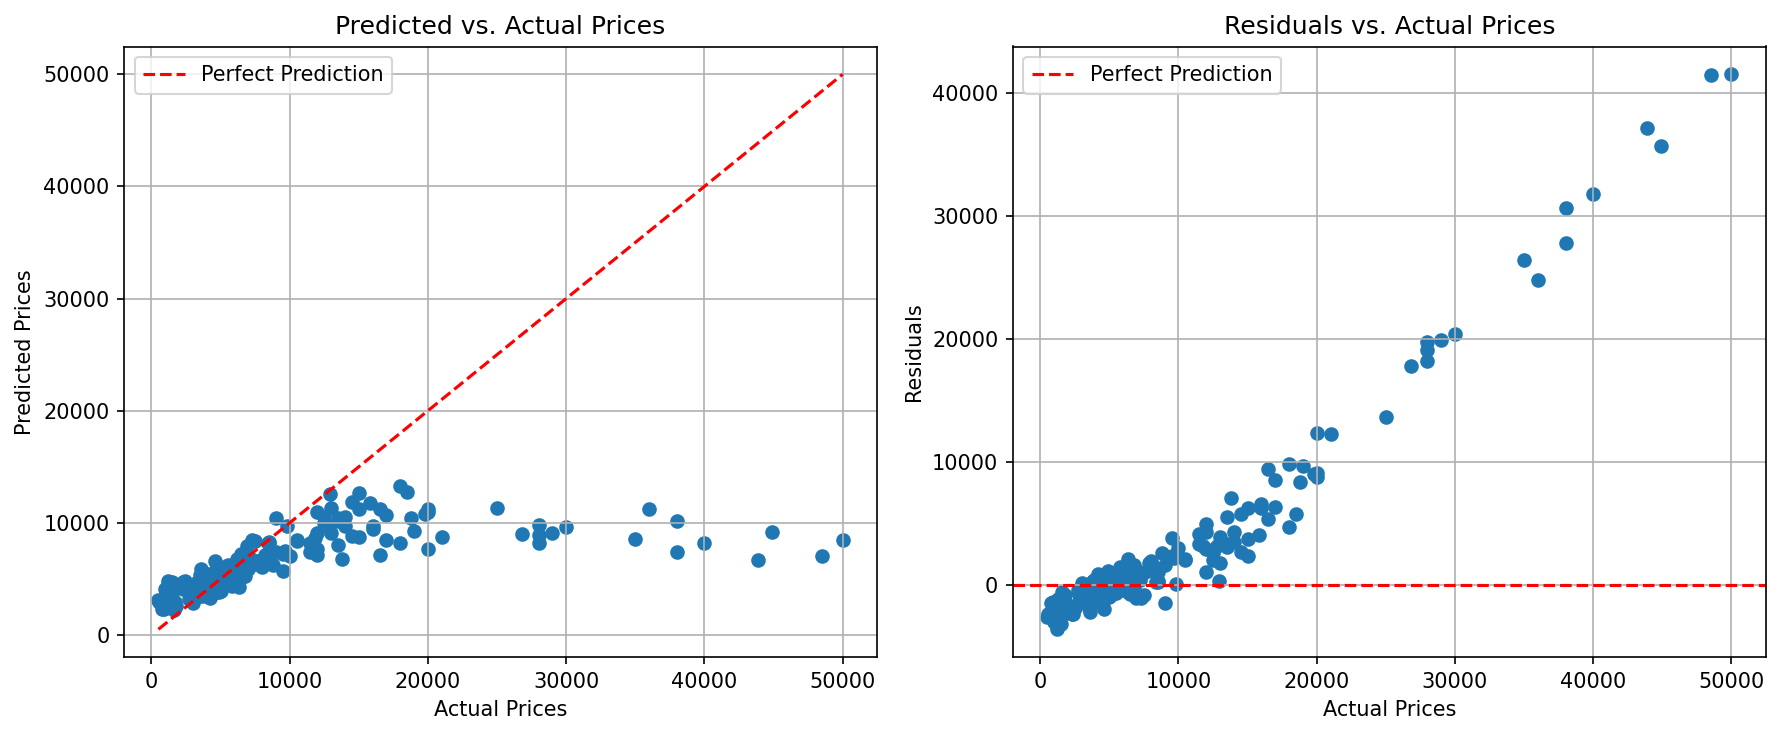

Model: RandomForestRegressor()
Outlier handling: OutlierHandler3SD()
Lower cutoff: -37337 S$/month
Upper cutoff: 56094 S$/month
Rental price outliers based on 3 SD: 29
Rental price outliers based on 3 SD: 2
RMSE: 3759.31
MAPE: 0.18
R-squared (R²): 0.81


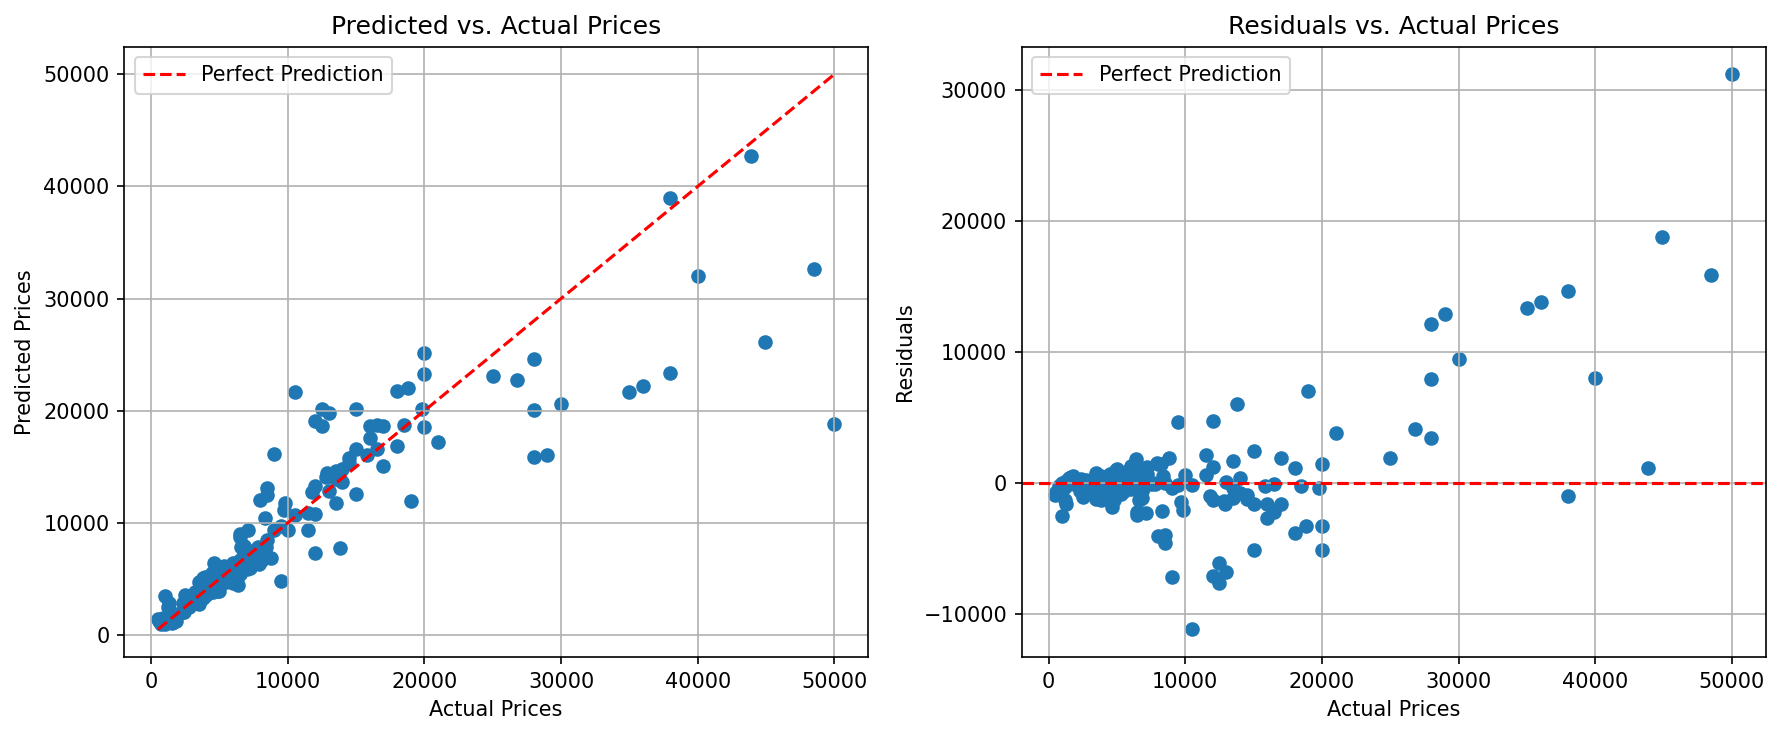

Model: MLPRegressor(max_iter=1000)
Outlier handling: OutlierHandler3SD()
Lower cutoff: -37337 S$/month
Upper cutoff: 56094 S$/month
Rental price outliers based on 3 SD: 29
Rental price outliers based on 3 SD: 2


C:\Users\Jens\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


RMSE: 4593.9
MAPE: 0.37
R-squared (R²): 0.71


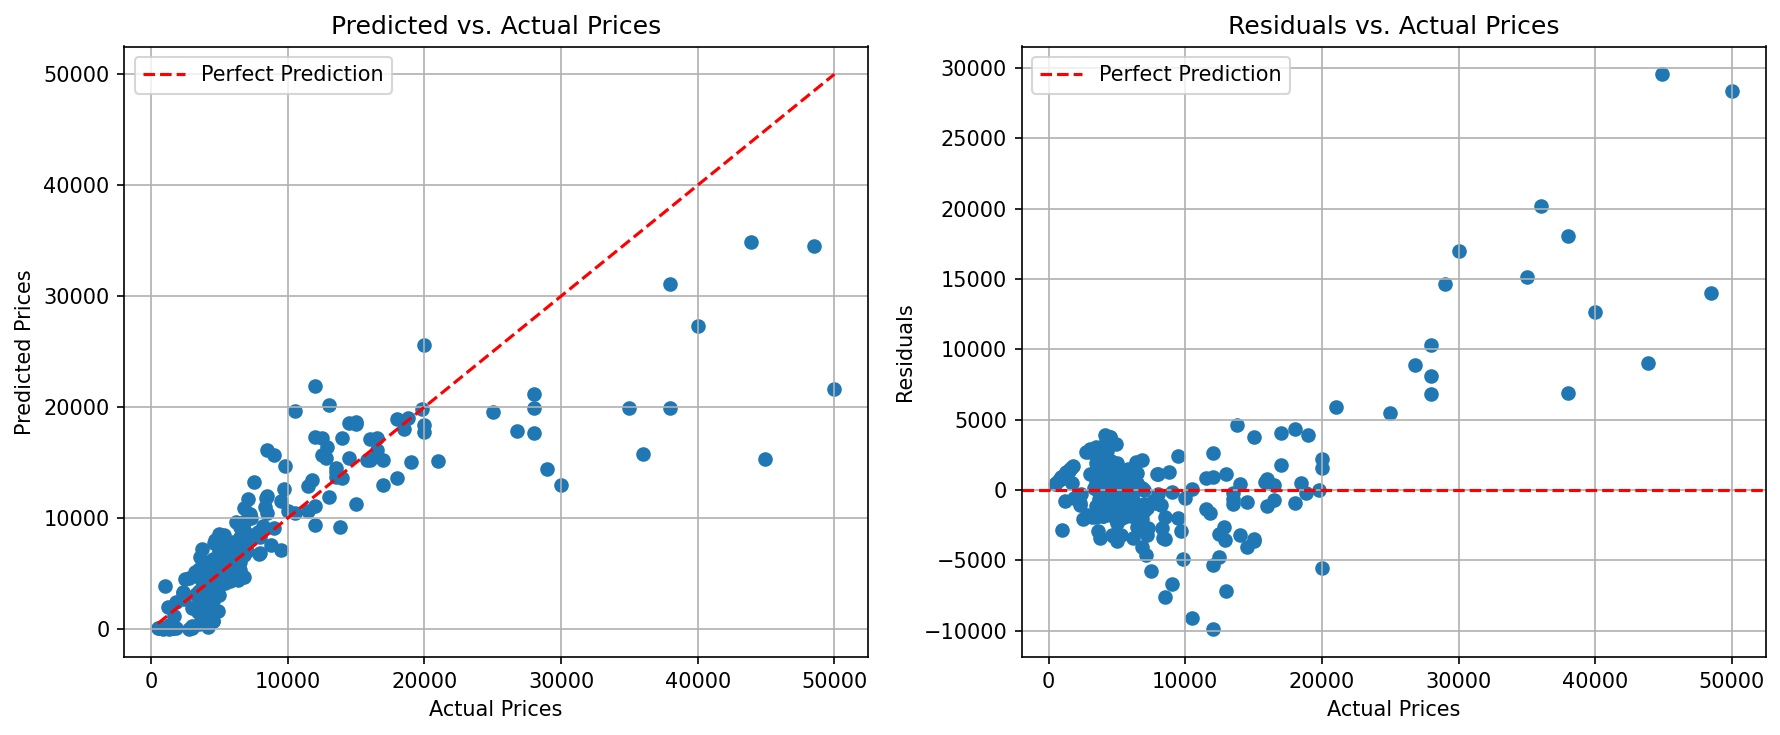

Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Outlier handling: OutlierHandler3SD()
Lower cutoff: -37337 S$/month
Upper cutoff: 56094 S$/month
Rental price outliers based on 3 SD: 29
Rental price outliers based on 3 SD: 2
RMSE: 3869.06
MAPE: 0.19
R-squared (R²): 0.8


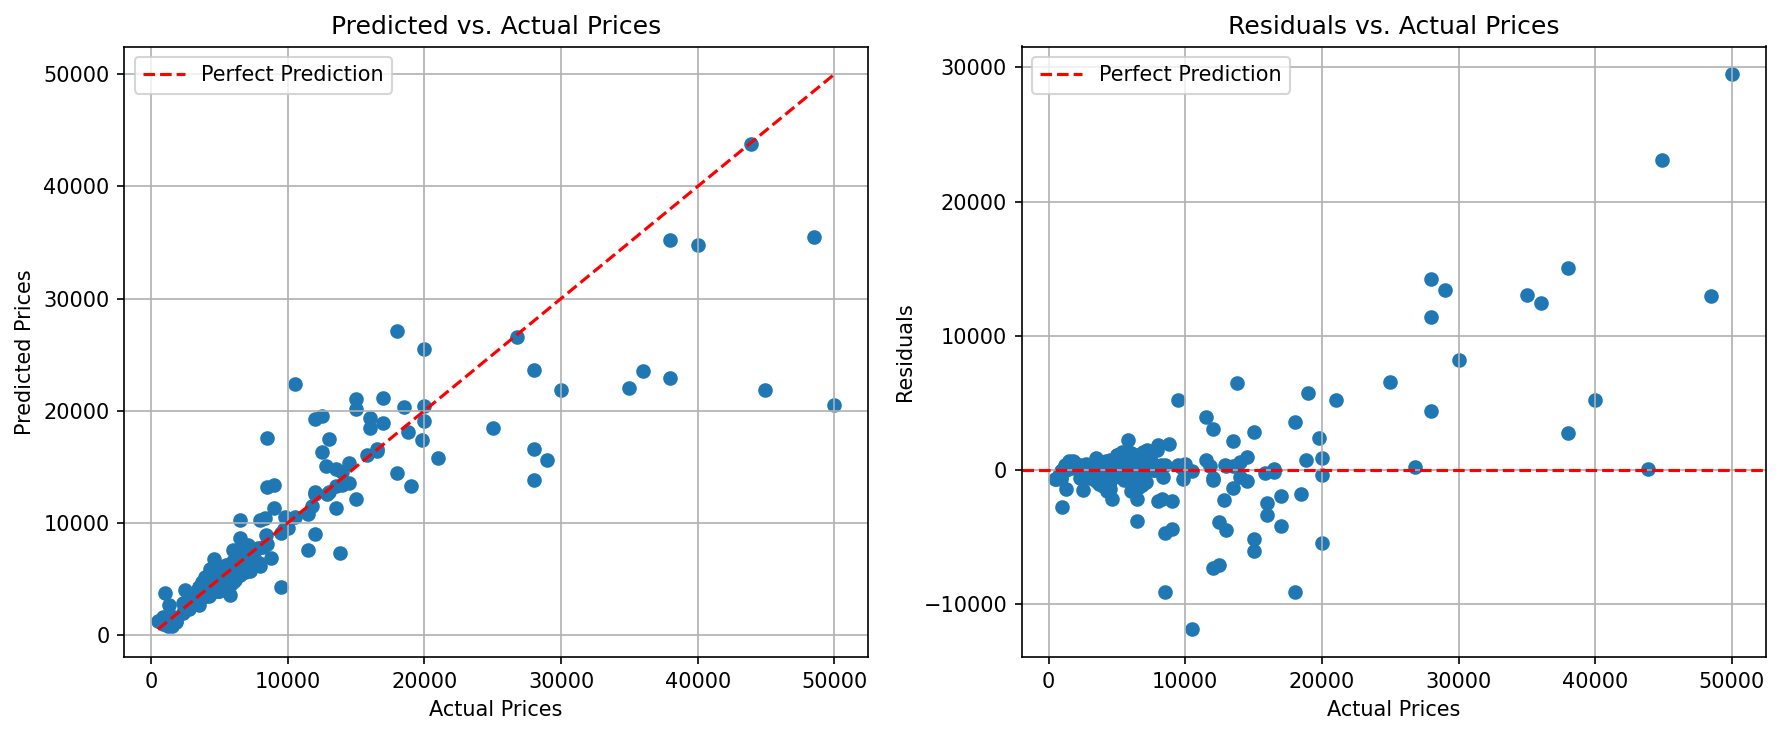

Model: LinearRegression()
Outlier handling: OutlierHandlerIQR()
Lower cutoff: -3000 S$/month
Upper cutoff: 15400 S$/month
Rental price outliers based on 1.5 IQR: 143
Rental price outliers based on 1.5 IQR: 35
RMSE: 1369.23
MAPE: 0.21
R-squared (R²): 0.83


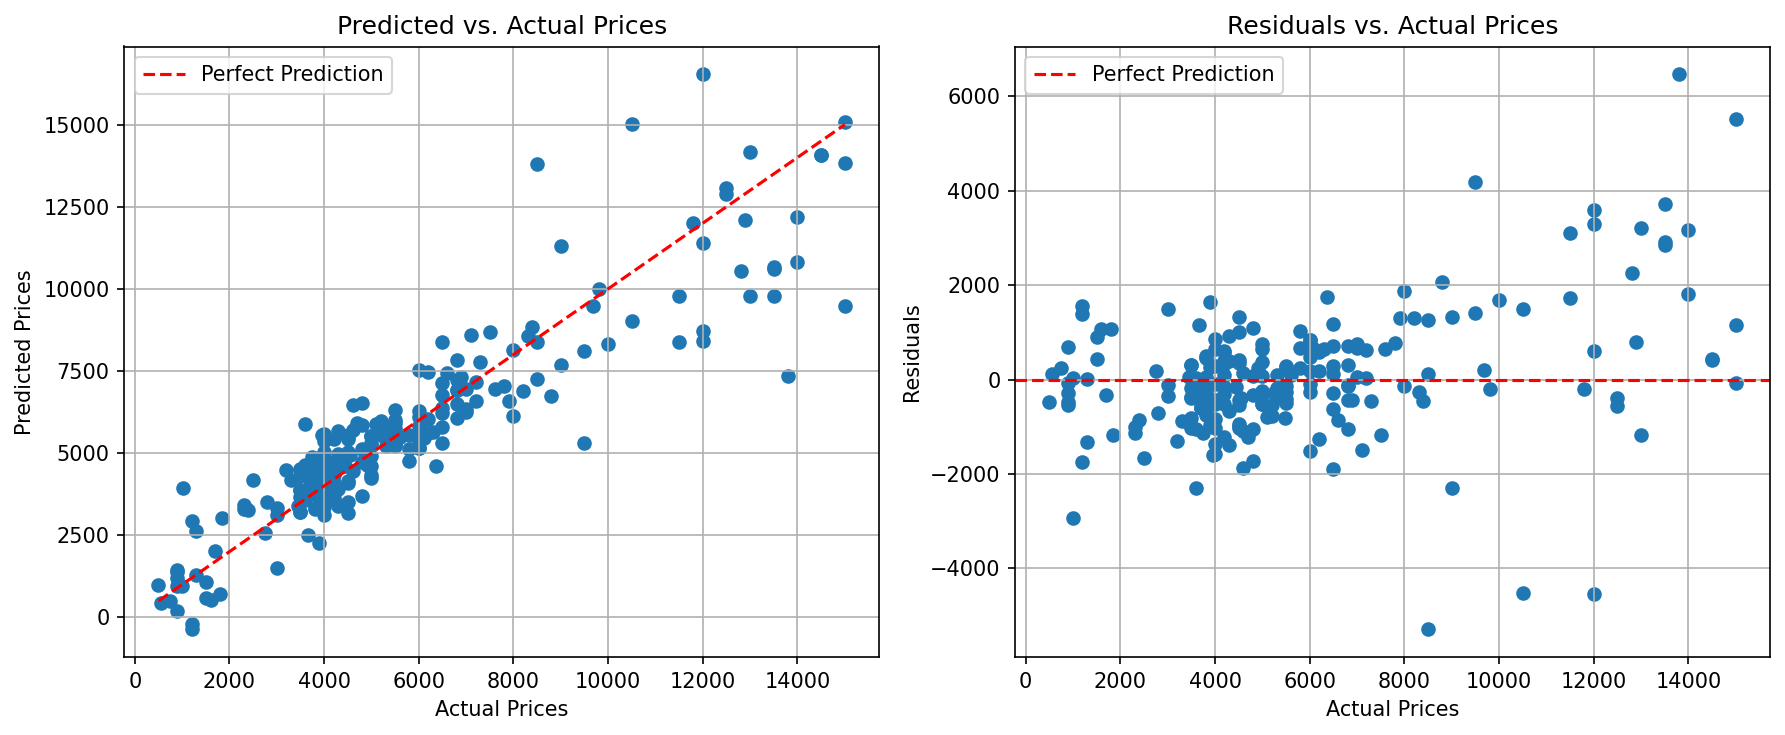

Model: SVR(C=100)
Outlier handling: OutlierHandlerIQR()
Lower cutoff: -3000 S$/month
Upper cutoff: 15400 S$/month
Rental price outliers based on 1.5 IQR: 143
Rental price outliers based on 1.5 IQR: 35
RMSE: 2087.18
MAPE: 0.33
R-squared (R²): 0.6


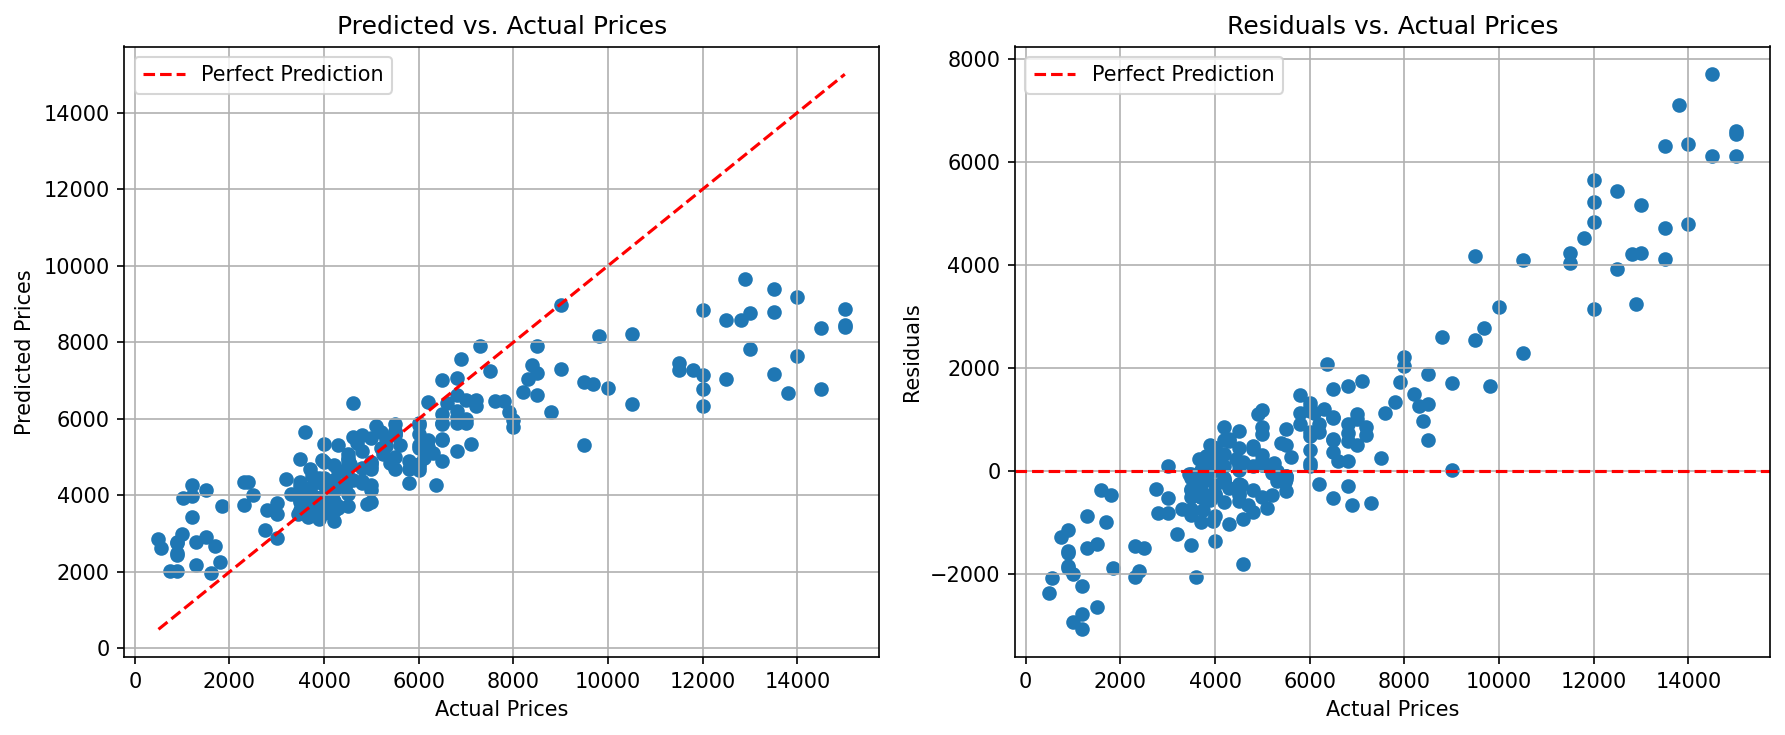

Model: RandomForestRegressor()
Outlier handling: OutlierHandlerIQR()
Lower cutoff: -3000 S$/month
Upper cutoff: 15400 S$/month
Rental price outliers based on 1.5 IQR: 143
Rental price outliers based on 1.5 IQR: 35
RMSE: 1110.43
MAPE: 0.15
R-squared (R²): 0.89


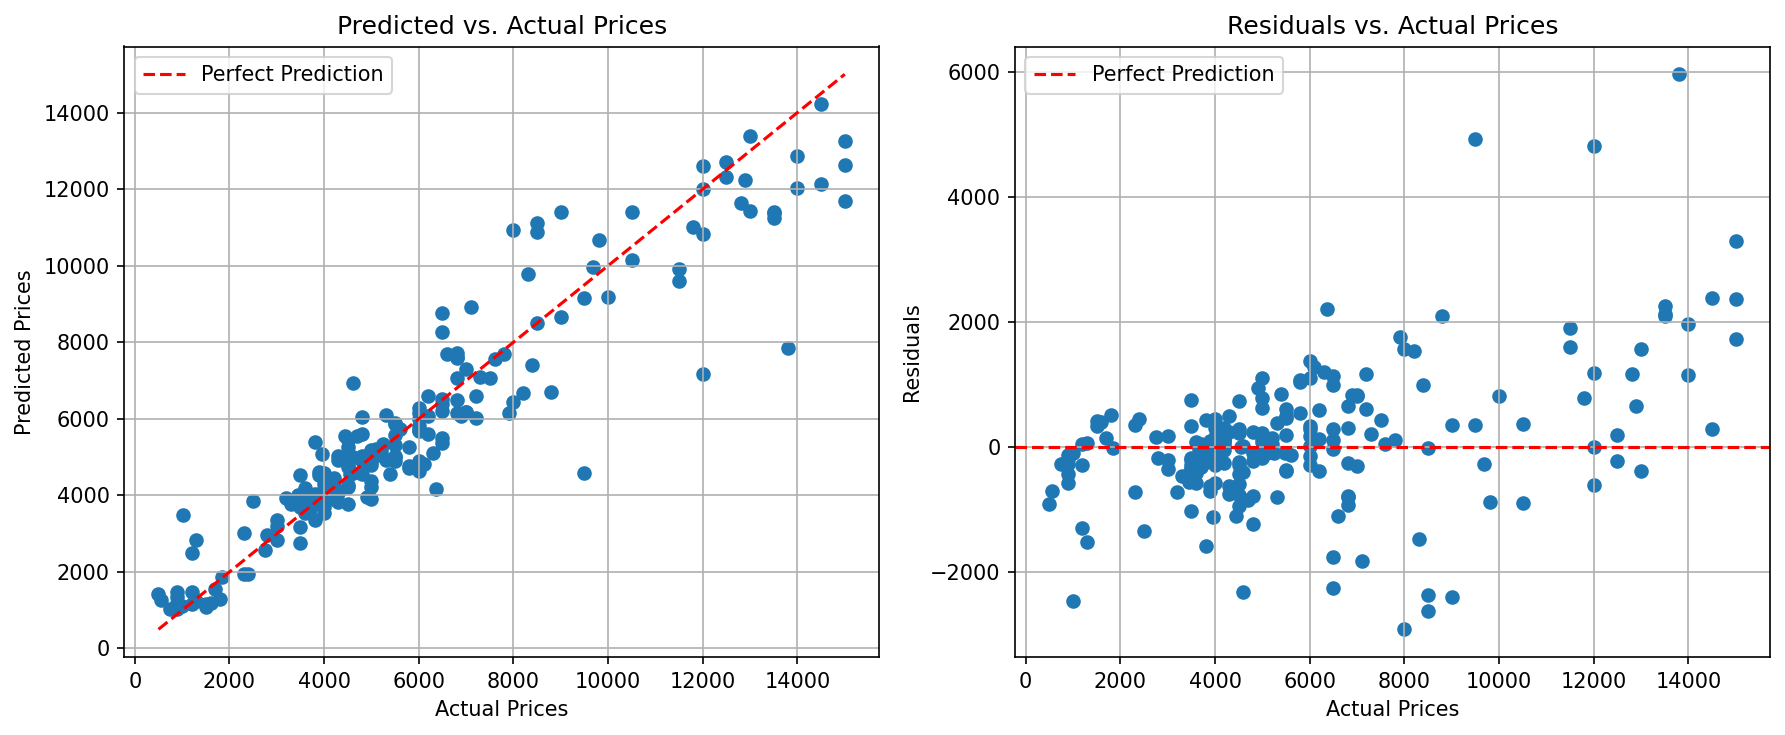

Model: MLPRegressor(max_iter=1000)
Outlier handling: OutlierHandlerIQR()
Lower cutoff: -3000 S$/month
Upper cutoff: 15400 S$/month
Rental price outliers based on 1.5 IQR: 143
Rental price outliers based on 1.5 IQR: 35


C:\Users\Jens\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


RMSE: 1369.94
MAPE: 0.19
R-squared (R²): 0.83


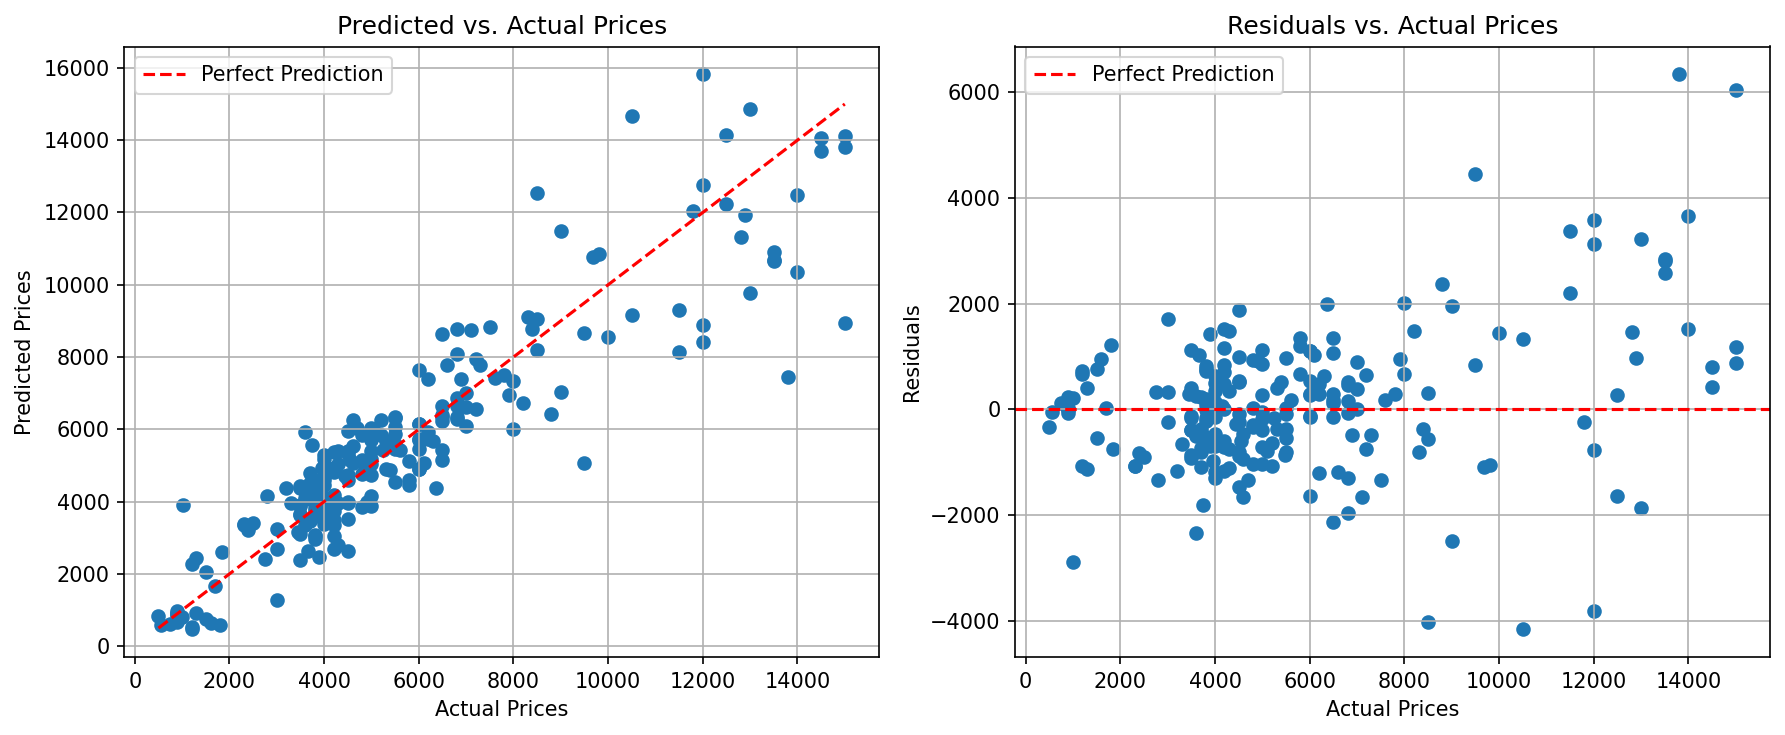

Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Outlier handling: OutlierHandlerIQR()
Lower cutoff: -3000 S$/month
Upper cutoff: 15400 S$/month
Rental price outliers based on 1.5 IQR: 143
Rental price outliers based on 1.5 IQR: 35
RMSE: 1150.66
MAPE: 0.15
R-squared (R²): 0.88


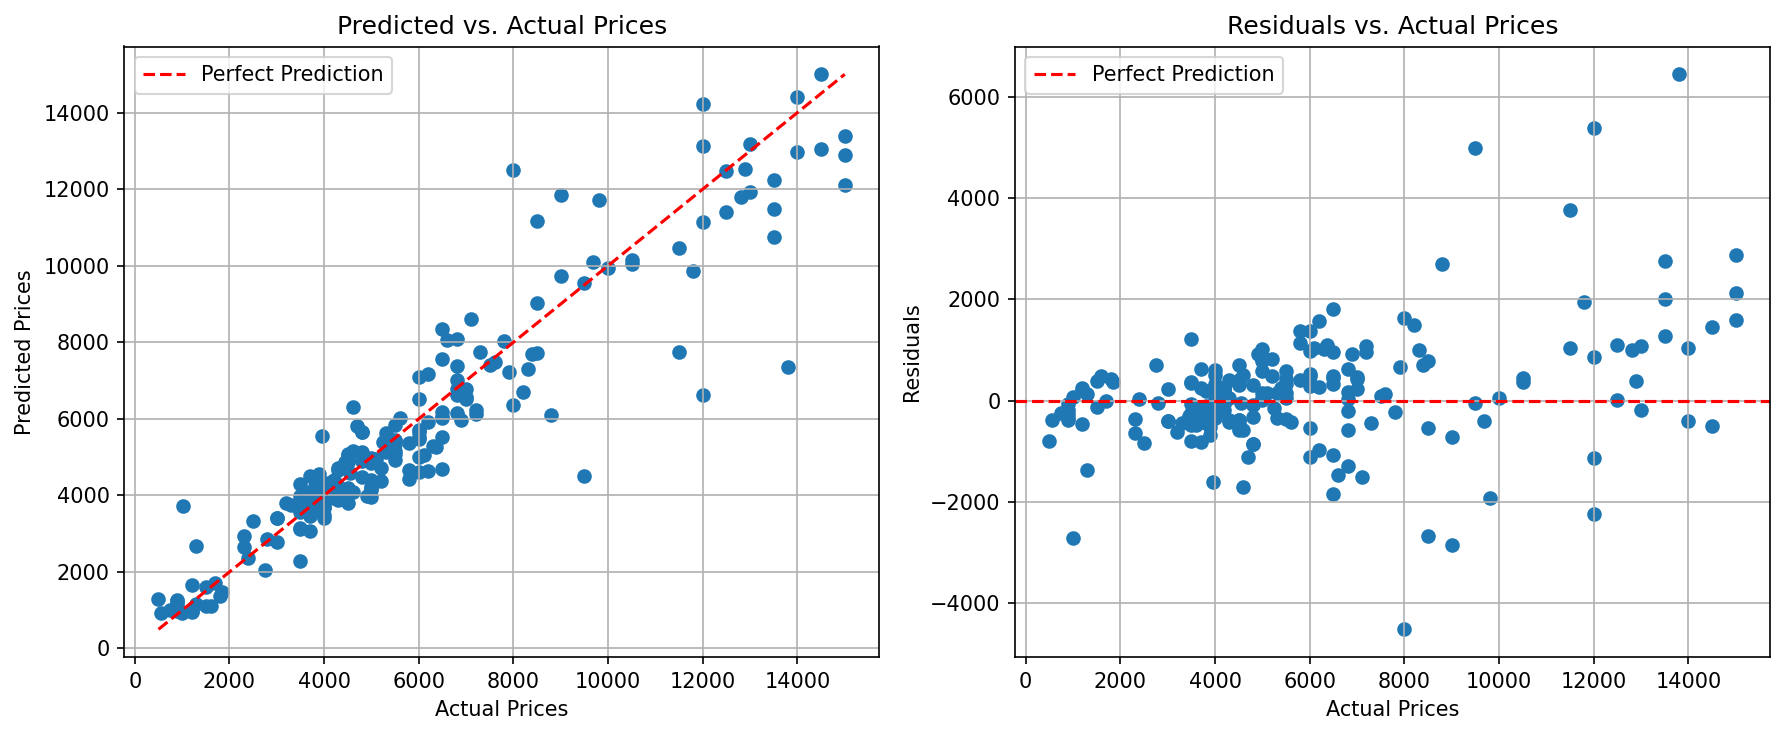

In [12]:
# Define outlier handlers
outlier_handlers = [None, OutlierHandler3SD(), OutlierHandlerIQR()]

# Define models
models = [LinearRegression(), SVR(C=100), RandomForestRegressor(), MLPRegressor(max_iter=1000), 
          XGBRegressor()]

# Define numerical, categorical and boolean columns 
numerical_columns = ["size", "bathrooms", "latitude", "longitude", "meters_to_mrt", "meters_to_cbd", 
                     "meters_to_school", "restaurants_rating", "year"]
categorical_columns = ["bedrooms", "property_type", "furnishing"]
boolean_columns = ["high_floor", "new", "renovated", "view", "penthouse"]

# Create lists for storing the RMSE, MAPE and R2 of each model 
rmse_ls = []
mape_ls = []
r2_ls = []

# Loop through each outlier handler
for outlier_handler in outlier_handlers:
    # Loop through each model
    for model in models:
        # Print outlier handler and model
        print("=" * 100)
        print(f"Model: {model}")
        print(f"Outlier handling: {outlier_handler}")
        
        # Remove outliers
        if outlier_handler is None:
            X_train_new = X_train.copy()
            y_train_new = y_train.copy()
            X_val_new = X_val.copy()
            y_val_new = y_val.copy()
        else:
            X_train_new, y_train_new = outlier_handler.fit_transform(X_train, y_train)
            X_val_new, y_val_new = outlier_handler.transform(X_val, y_val)

        # Scale numerical columns and encode categorical columns 
        column_transformer = ColumnTransformer(
            transformers=[
                ("scaler", StandardScaler(), numerical_columns),
                ("encoder", OneHotEncoder(drop=None, sparse_output=False), categorical_columns)
            ],
            remainder="passthrough"  # Include the boolean columns without transformation
        )

        # Create a pipeline
        pipeline = Pipeline(steps=[
            ("column_transformer", column_transformer),
            ("model", model)
        ])

        # Fit the pipeline on the training data
        pipeline.fit(X_train_new, y_train_new)
        
        # Predict on the validation data
        y_val_pred = pipeline.predict(X_val_new)
        
        # Calculate evaluation metrics: RMSE, MAPE, R2
        rmse = mean_squared_error(y_val_new, y_val_pred, squared=False)
        mape = mean_absolute_percentage_error(y_val_new, y_val_pred)
        r2 = r2_score(y_val_new, y_val_pred)
        print(f"RMSE: {round(rmse, 2)}")
        print(f"MAPE: {round(mape, 2)}")
        print(f"R-squared (R²): {round(r2, 2)}")
        
        # Add the RMSE, MAPE and R2 to their respective lists
        rmse_ls.append(rmse)
        mape_ls.append(mape)
        r2_ls.append(r2)
        
        # Create residual plots
        # Calculate residuals
        residuals = [actual_value - predicted_value for actual_value, predicted_value in zip(y_val_new, y_val_pred)]

        # Create a 1x2 grid of subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

        # Plot 1: Predicted vs. Actual Prices
        axes[0].scatter(y_val_new, y_val_pred)
        axes[0].plot([min(y_val_new), max(y_val_new)], 
                     [min(y_val_new), max(y_val_new)], 
                     color="red", 
                     linestyle="--", 
                     label="Perfect Prediction")  # Add diagonal reference line
        axes[0].set_xlabel("Actual Prices")
        axes[0].set_ylabel("Predicted Prices")
        axes[0].set_title("Predicted vs. Actual Prices")
        axes[0].grid(True)
        axes[0].legend() 

        # Plot 2: Residuals vs. Actual Prices
        axes[1].scatter(y_val_new, residuals)
        axes[1].axhline(y=0, color="red", linestyle="--", label="Perfect Prediction")  # Add horizontal reference line
        axes[1].set_xlabel("Actual Prices")
        axes[1].set_ylabel("Residuals")
        axes[1].set_title("Residuals vs. Actual Prices")
        axes[1].grid(True)
        axes[1].legend() 

        # Adjust layout and display the plots
        plt.tight_layout()
        plt.show()

In [13]:
# Comparison tables of model metrics
# No outlier handling 
comparison_table = pd.DataFrame({
    "Model": ["Linear Regression", "Support Vector Machine", "Random Forest", "Neural Network", "XGBoost"],
    "RMSE": [rmse_ls[0], rmse_ls[1], rmse_ls[2], rmse_ls[3], rmse_ls[4]],
    "MAPE": [mape_ls[0], mape_ls[1], mape_ls[2], mape_ls[3], mape_ls[4]],
    "R-squared (R²)": [r2_ls[0], r2_ls[1], r2_ls[2], r2_ls[3], r2_ls[4]]
})

# Removing outliers based on 3 SD 
comparison_table_3sd = pd.DataFrame({
    "Model": ["Linear Regression", "Support Vector Machine", "Random Forest", "Neural Network", "XGBoost"],
    "RMSE": [rmse_ls[5], rmse_ls[6], rmse_ls[7], rmse_ls[8], rmse_ls[9]],
    "MAPE": [mape_ls[5], mape_ls[6], mape_ls[7], mape_ls[8], mape_ls[9]],
    "R-squared (R²)": [r2_ls[5], r2_ls[6], r2_ls[7], r2_ls[8], r2_ls[9]]
})

# Removing outliers based on 1.5 IQR 
comparison_table_iqr = pd.DataFrame({
    "Model": ["Linear Regression", "Support Vector Machine", "Random Forest", "Neural Network", "XGBoost"],
    "RMSE": [rmse_ls[10], rmse_ls[11], rmse_ls[12], rmse_ls[13], rmse_ls[14]],
    "MAPE": [mape_ls[10], mape_ls[11], mape_ls[12], mape_ls[13], mape_ls[14]],
    "R-squared (R²)": [r2_ls[10], r2_ls[11], r2_ls[12], r2_ls[13], r2_ls[14]]
})

# Show model comparison tables
print("No outlier handling")
print(round(comparison_table, 2))
print("=" * 60)
print("Removing outliers based on 3 SD")
print(round(comparison_table_3sd, 2))
print("=" * 60)
print("Removing outliers based on 1.5 IQR")
print(round(comparison_table_iqr, 2))

No outlier handling
                    Model     RMSE  MAPE  R-squared (R²)
0       Linear Regression  6224.43  0.37            0.62
1  Support Vector Machine  9138.99  0.40            0.19
2           Random Forest  4897.20  0.19            0.77
3          Neural Network  6291.21  0.58            0.62
4                 XGBoost  4699.09  0.21            0.79
Removing outliers based on 3 SD
                    Model     RMSE  MAPE  R-squared (R²)
0       Linear Regression  3896.71  0.28            0.79
1  Support Vector Machine  7579.40  0.38            0.22
2           Random Forest  3759.31  0.18            0.81
3          Neural Network  4593.90  0.37            0.71
4                 XGBoost  3869.06  0.19            0.80
Removing outliers based on 1.5 IQR
                    Model     RMSE  MAPE  R-squared (R²)
0       Linear Regression  1369.23  0.21            0.83
1  Support Vector Machine  2087.18  0.33            0.60
2           Random Forest  1110.43  0.15            0.89
3

Conclusions: 
1. Random forest and XGBoost demonstrate better model performance than linear regression, support vector machine, and neural network across all model metrics (RMSE, MAPE, R2). 
2. Removing outliers based on 1.5 IQR yields better model performance than removing outliers based on 3 SD or not handling outliers.
3. For hyperparameter tuning, use random forest and XGBoost and remove outliers based on 1.5 IQR.

# Hyperparameter tuning

In [21]:
# Remove outliers
outlier_handler_iqr = OutlierHandlerIQR()
X_train_new, y_train_new = outlier_handler_iqr.fit_transform(X_train, y_train)

Lower cutoff: -3000 S$/month
Upper cutoff: 15400 S$/month
Rental price outliers based on 1.5 IQR: 143


In [22]:
# Scale numerical columns and encode categorical columns 
column_transformer = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), numerical_columns),
        ("encoder", OneHotEncoder(drop=None, sparse_output=False), categorical_columns)
    ],
    remainder="passthrough"  # Include the boolean columns without transformation
)

X_train_new = column_transformer.fit_transform(X_train_new)

## Random forest

In [ ]:
# Create a random forest model
rf = RandomForestRegressor(random_state=42)

# Define hyperparameter grid 
rf_param_grid = {
    "n_estimators": [200, 300, 400, 500],               
    "max_depth": [20, 30, 40, 50],              
    "max_features": [0.33, 0.5, 0.66, 1]                
}

# Create a grid search object
rf_grid_search = GridSearchCV(estimator=rf, 
                              param_grid=rf_param_grid, 
                              cv=5, 
                              scoring="neg_root_mean_squared_error")

# Fit the grid search to the training data
rf_grid_search.fit(X_train_new, y_train_new)

In [ ]:
# Create grid search results dataframe with validation score (RMSE) and parameter values
rf_grid_search_results = pd.DataFrame({"validation_rmse": -1 * rf_grid_search.cv_results_["mean_test_score"], 
                                       "parameters": rf_grid_search.cv_results_["params"]}) 

# Extract each parameter as a separate column
rf_grid_search_results["n_estimators"] = rf_grid_search_results["parameters"].apply(lambda x: x["n_estimators"])
rf_grid_search_results["max_depth"] = rf_grid_search_results["parameters"].apply(lambda x: x["max_depth"])
rf_grid_search_results["max_features"] = rf_grid_search_results["parameters"].apply(lambda x: x["max_features"])

# Delete the parameters column
rf_grid_search_results = rf_grid_search_results.drop("parameters", axis=1)

# Show the top 10 best performing models
rf_grid_search_results.sort_values("validation_rmse")[:10]

In [ ]:
# Create best random forest model
rf_best_model = RandomForestRegressor(n_estimators=400, max_depth=30, max_features=0.5, random_state=42)

## XGBoost

In [ ]:
# Create XGBoost model
xgb = XGBRegressor(random_state=42)

# Define hyperparameter grid 
xgb_param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],               
    "max_depth": [3, 4, 5], 
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],  
    "learning_rate": [0.01, 0.1],
    "min_child_weight": [1, 2, 3],
    "gamma": [0, 0.1, 0.2],           
}

# Create a grid search object
xgb_grid_search = GridSearchCV(estimator=xgb,
                               param_grid=xgb_param_grid, 
                               cv=5, 
                               scoring="neg_root_mean_squared_error")

# Fit the grid search to the training data
xgb_grid_search.fit(X_train_new, y_train_new)

In [ ]:
# Create grid search results dataframe with validation score (RMSE) and parameter values
xgb_grid_search_results = pd.DataFrame({"validation_rmse": -1 * xgb_grid_search.cv_results_["mean_test_score"], 
                                       "parameters": xgb_grid_search.cv_results_["params"]}) 

# Extract each parameter as a separate column
xgb_grid_search_results["n_estimators"] = xgb_grid_search_results["parameters"].apply(lambda x: x["n_estimators"])
xgb_grid_search_results["max_depth"] = xgb_grid_search_results["parameters"].apply(lambda x: x["max_depth"])
xgb_grid_search_results["subsample"] = xgb_grid_search_results["parameters"].apply(lambda x: x["subsample"])
xgb_grid_search_results["colsample_bytree"] = xgb_grid_search_results["parameters"].apply(lambda x: x["colsample_bytree"])
xgb_grid_search_results["learning_rate"] = xgb_grid_search_results["parameters"].apply(lambda x: x["learning_rate"])
xgb_grid_search_results["min_child_weight"] = xgb_grid_search_results["parameters"].apply(lambda x: x["min_child_weight"])
xgb_grid_search_results["gamma"] = xgb_grid_search_results["parameters"].apply(lambda x: x["gamma"])

# Delete the parameters column
xgb_grid_search_results = xgb_grid_search_results.drop("parameters", axis=1)

# Show the top 10 best performing models
xgb_grid_search_results.sort_values("validation_rmse")[:10]

Conclusion: Best performing model was an XGBoost regressor with 300 trees, maximum tree depth of 4, random subsample of 80% of the training data for each tree, random subsample of 80% of the features for each tree, a learning rate of 0.1, and a min_child_weight of 3.

# Final model

In [25]:
# Create final model
xgb_final_model = XGBRegressor(n_estimators=300, max_depth=4, subsample=0.8, colsample_bytree=0.8, learning_rate=0.1,
                               min_child_weight=3, random_state=42)

# Train model
xgb_final_model.fit(X_train_new, y_train_new)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

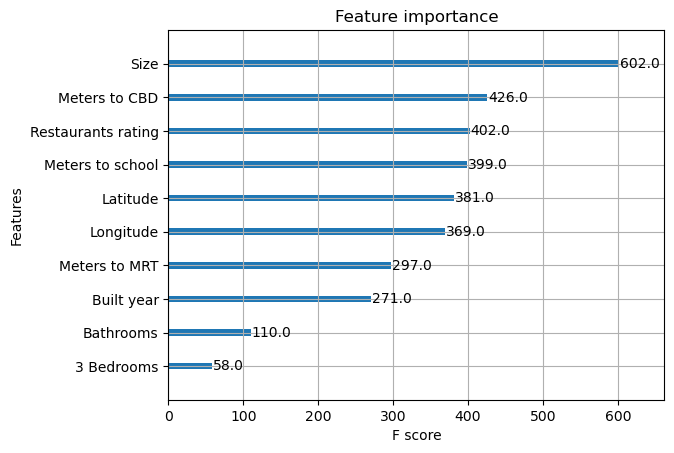

In [29]:
# Plot feature importance
# Mapping of feature names for better readability
feature_mapping = {
    "f0": "Size",
    "f1": "Bathrooms",
    "f2": "Latitude",
    "f3": "Longitude",
    "f4": "Meters to MRT",
    "f5": "Meters to CBD",
    "f6": "Meters to school",
    "f7": "Restaurants rating",
    "f8": "Built year",
    "f11": "3 Bedrooms"
}

# Create plot
xgb.plot_importance(xgb_final_model, max_num_features=10)

# Apply mapping of feature names
plt.gca().set_yticklabels([feature_mapping.get(label.get_text(), label.get_text()) 
                           for label in plt.gca().get_yticklabels()])

plt.show()

In [32]:
# Remove outliers in validation and test data
X_val_new, y_val_new = outlier_handler_iqr.transform(X_val, y_val)
X_test_new, y_test_new = outlier_handler_iqr.transform(X_test, y_test)

# Scale numerical columns and encode categorical columns in validation and test data
X_val_new = column_transformer.transform(X_val_new)
X_test_new = column_transformer.transform(X_test_new)

# Predict on the validation and test data
y_val_pred = xgb_final_model.predict(X_val_new)
y_test_pred = xgb_final_model.predict(X_test_new)

# Calculate evaluation metrics on validation data
rmse = mean_squared_error(y_val_new, y_val_pred, squared=False)
mape = mean_absolute_percentage_error(y_val_new, y_val_pred)
r2 = r2_score(y_val_new, y_val_pred)
print("=" * 40)
print("VALIDATION DATA")
print(f"RMSE: {round(rmse, 2)}")
print(f"MAPE: {round(mape, 2)}")
print(f"R-squared (R²): {round(r2, 2)}")
print("=" * 40)

# Calculate evaluation metrics on test data
mae = mean_absolute_error(y_test_new, y_test_pred)
rmse = mean_squared_error(y_test_new, y_test_pred, squared=False)
mape = mean_absolute_percentage_error(y_test_new, y_test_pred)
r2 = r2_score(y_test_new, y_test_pred)
print("TEST DATA")
print(f"RMSE: {round(rmse, 2)}")
print(f"MAPE: {round(mape, 2)}")
print(f"R-squared (R²): {round(r2, 2)}")

Rental price outliers based on 1.5 IQR: 35
Rental price outliers based on 1.5 IQR: 28
VALIDATION DATA
RMSE: 1039.95
MAPE: 0.14
R-squared (R²): 0.9
TEST DATA
RMSE: 995.47
MAPE: 0.13
R-squared (R²): 0.9
